In [1]:
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kafka import KafkaConsumer
from sklearn.metrics import f1_score
import copy
from sklearn.preprocessing import StandardScaler
from collections import deque
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

In [2]:
with open('phase2scaler.pkl', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)

with open('models/XGB_phase2_model.pkl','rb') as model_file:
    xgb_model = pickle.load(model_file)

print("Scaler and XGB model loaded successfully!")

Scaler and XGB model loaded successfully!


In [3]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False,
    consumer_timeout_ms=5000
)

if consumer.bootstrap_connected():
    print("Successfully connected to Kafka broker")
else:
    print("Couldn't connect to bootstrap server.")

Successfully connected to Kafka broker


In [4]:
static_model = xgb_model
dynamic_model = copy.deepcopy(xgb_model)

In [5]:
static_scaler = scaler
dynamic_scaler = copy.deepcopy(scaler)

feature_columns = scaler.feature_names_in_  # list of feature column names
window_size = 1000
max_window_steps = 15
window_count = 0
window_data = deque(maxlen=window_size)

dynamic_model_f1 = []
static_model_f1 = []

ema_alpha = 0.3

In [6]:
feature_columns = list(scaler.feature_names_in_)  # Ensure it's a list
if 'label' not in feature_columns:
    feature_columns.append('label')

In [7]:
print("Starting to consume messages...")

for idx, message in enumerate(consumer):
    # Decode and split the incoming message
    row = message.value.decode().strip().split(',')

    # Check if the row has at least enough columns for the features
    if len(row) < len(feature_columns) - 1:
        continue

    # Extract only the columns corresponding to feature_columns (excluding 'label')
    try:
        row_data = {feature: row[i] for i, feature in enumerate(feature_columns[:-1])}
        row_data['label'] = row[-1] if len(row) >= len(feature_columns) else None
        row_df = pd.DataFrame([row_data])
    except Exception:
        continue

    # Clean and validate the 'label' column
    if 'label' in row_df.columns:
        row_df['label'] = row_df['label'].apply(lambda x: x.strip().replace('\\n"', '').replace('"', ''))
        row_df = row_df[pd.to_numeric(row_df['label'], errors='coerce').notnull()]
        if row_df.empty:
            continue
        row_df['label'] = row_df['label'].astype(int)
    else:
        continue

    # Convert feature columns to numeric, filling NaNs with 0
    for col in feature_columns[:-1]:
        row_df[col] = pd.to_numeric(row_df[col], errors='coerce').fillna(0)

    # Scale the features (excluding 'label')
    X_new_dynamic = dynamic_scaler.transform(row_df[feature_columns[:-1]])
    X_new_static = static_scaler.transform(row_df[feature_columns[:-1]])

    y_new = int(row_df['label'].values[0])

    # Make predictions
    dynamic_pred = dynamic_model.predict(X_new_dynamic)[0]
    static_pred = static_model.predict(X_new_static)[0]

    # Append data to the window
    window_data.append((X_new_dynamic[0], y_new, dynamic_pred, static_pred))

    if idx % 100 == 0:
        print(f"Consumed {idx} messages")

    # Process the window when it's full
    if len(window_data) == window_size:
        # Extract ground truth and predictions from the window
        y_true = np.array([entry[1] for entry in window_data])
        dynamic_preds = np.array([entry[2] for entry in window_data])
        static_preds = np.array([entry[3] for entry in window_data])

        # Compute metrics
        current_dynamic_f1 = f1_score(y_true, dynamic_preds, average='weighted')
        current_static_f1 = f1_score(y_true, static_preds, average='weighted')

        print(f"\nWindow complete:")
        print(f"  Dynamic Model -> F1: {current_dynamic_f1:.3f}")
        print(f"  Static Model  -> F1: {current_static_f1:.3f}")

        dynamic_model_f1.append(current_dynamic_f1)
        static_model_f1.append(current_static_f1)

        # Retrain if the F1-score is below the threshold
        if current_dynamic_f1 < 0.92:
            print(f"Dynamic model F1 ({current_dynamic_f1:.3f}) is below threshold. Retraining dynamic model on this window...")
            X_window = np.array([entry[0] for entry in window_data])
            y_window = np.array([entry[1] for entry in window_data])

            X_window_df = pd.DataFrame(X_window, columns=feature_columns[:-1])
            new_scaler = StandardScaler()
            new_scaler.fit(X_window_df)

            # Update the dynamic scaler gradually (EMA update)
            dynamic_scaler.mean_ = (1 - ema_alpha) * dynamic_scaler.mean_ + ema_alpha * new_scaler.mean_
            dynamic_scaler.scale_ = (1 - ema_alpha) * dynamic_scaler.scale_ + ema_alpha * new_scaler.scale_

            # Retrain the dynamic model on the window data
            dynamic_model.fit(X_window, y_window)

        # Clear the window for the next batch
        window_data.clear()
        window_count += 1
        if window_count >= max_window_steps:
            print(f"Reached max window steps ({max_window_steps}). Exiting...")
            break

print("Finished streaming from Kafka or timed out.")

Starting to consume messages...
Consumed 100 messages
Consumed 200 messages
Consumed 300 messages
Consumed 400 messages
Consumed 500 messages
Consumed 600 messages
Consumed 700 messages
Consumed 800 messages
Consumed 900 messages
Consumed 1000 messages

Window complete:
  Dynamic Model -> F1: 0.462
  Static Model  -> F1: 0.462
Dynamic model F1 (0.462) is below threshold. Retraining dynamic model on this window...
Consumed 1100 messages
Consumed 1200 messages
Consumed 1300 messages
Consumed 1400 messages
Consumed 1500 messages
Consumed 1600 messages
Consumed 1700 messages
Consumed 1800 messages
Consumed 1900 messages
Consumed 2000 messages

Window complete:
  Dynamic Model -> F1: 0.462
  Static Model  -> F1: 0.491
Dynamic model F1 (0.462) is below threshold. Retraining dynamic model on this window...
Consumed 2100 messages
Consumed 2200 messages
Consumed 2300 messages
Consumed 2400 messages
Consumed 2500 messages
Consumed 2600 messages
Consumed 2700 messages
Consumed 2800 messages
Consu

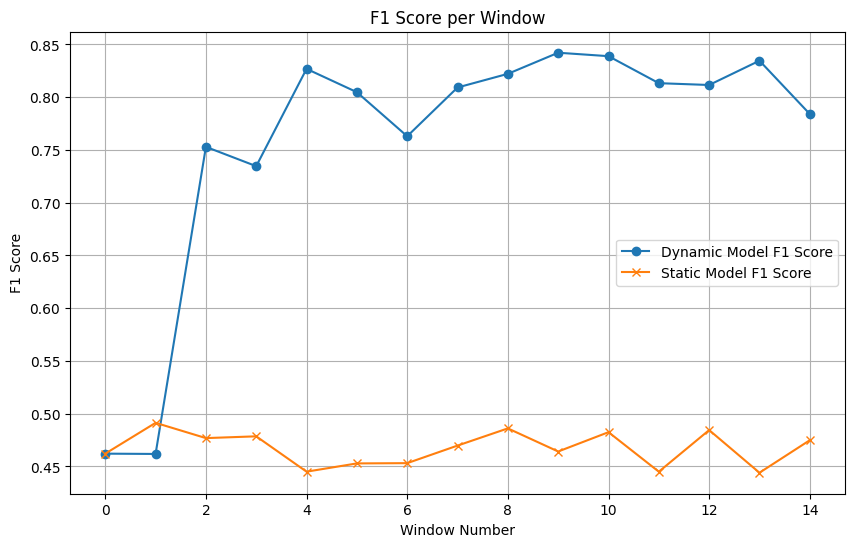

In [8]:
import matplotlib.pyplot as plt

# Plotting F1 scores per window
plt.figure(figsize=(10, 6))
plt.plot(dynamic_model_f1, label='Dynamic Model F1 Score', marker='o')
plt.plot(static_model_f1, label='Static Model F1 Score', marker='x')
plt.xlabel('Window Number')
plt.ylabel('F1 Score')
plt.title('F1 Score per Window')
plt.legend()
plt.grid(True)
plt.show()